In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

LISTINGSFILE = '../data/airbnb/listings.csv'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols)
df.head(10)

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,De Baarsjes - Oud-West,Entire home/apt,6,2.0,6.0,$145.00,14,4,95.0,f,moderate,0.68
1,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,$88.00,0,17,93.0,f,moderate,0.56
2,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,$130.00,7,4,100.0,f,strict,2.40
3,De Baarsjes - Oud-West,Entire home/apt,4,2.0,3.0,$110.00,0,2,100.0,f,moderate,0.24
4,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,$115.00,3,10,96.0,f,moderate,0.46
5,De Baarsjes - Oud-West,Private room,1,1.0,1.0,$70.00,5,11,83.0,f,moderate,1.59
6,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,$120.00,1,3,100.0,f,moderate,0.98
7,De Baarsjes - Oud-West,Private room,2,1.0,1.0,$45.00,4,33,98.0,f,strict,5.27
8,De Baarsjes - Oud-West,Private room,2,1.0,NaN,$45.00,0,2,97.0,f,flexible,0.04
9,De Baarsjes - Oud-West,Entire home/apt,4,2.0,3.0,$240.00,0,13,97.0,f,moderate,0.56


### EDA

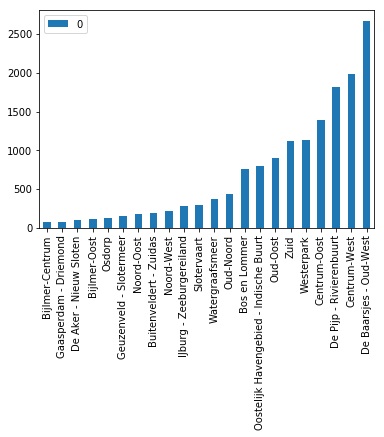

In [2]:
%matplotlib inline
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

### 데이터 전처리

In [4]:
df['reviews_per_month'].fillna(0, inplace=True)

df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

# 방 개수 별로 모델 생성
df = df[df.bedrooms == 1]

df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.head(5)

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
1,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,88.0,0,17,93.0,f,moderate,0.56
2,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,130.0,7,4,100.0,f,strict,2.40
4,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,115.0,3,10,96.0,f,moderate,0.46
5,De Baarsjes - Oud-West,Private room,1,1.0,1.0,70.0,5,11,83.0,f,moderate,1.59
6,De Baarsjes - Oud-West,Entire home/apt,2,1.0,1.0,120.0,1,3,100.0,f,moderate,0.98


### 범주형 변수 변환

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

category_variable = ['neighbourhood_cleansed', 'room_type', 'cancellation_policy', 'instant_bookable']
category_df = df[category_variable]
category_df = category_df.apply(le.fit_transform)
alldata = pd.concat((df.drop(category_variable, axis=1), category_df), axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,neighbourhood_cleansed,room_type,cancellation_policy,instant_bookable
0,6,2.0,6.0,$145.00,14,4,95.0,0.68,7,0,1,0
1,2,1.0,1.0,$88.00,0,17,93.0,0.56,7,0,1,0
2,2,1.0,1.0,$130.00,7,4,100.0,2.40,7,0,2,0
3,4,2.0,3.0,$110.00,0,2,100.0,0.24,7,0,1,0
4,2,1.0,1.0,$115.00,3,10,96.0,0.46,7,0,1,0


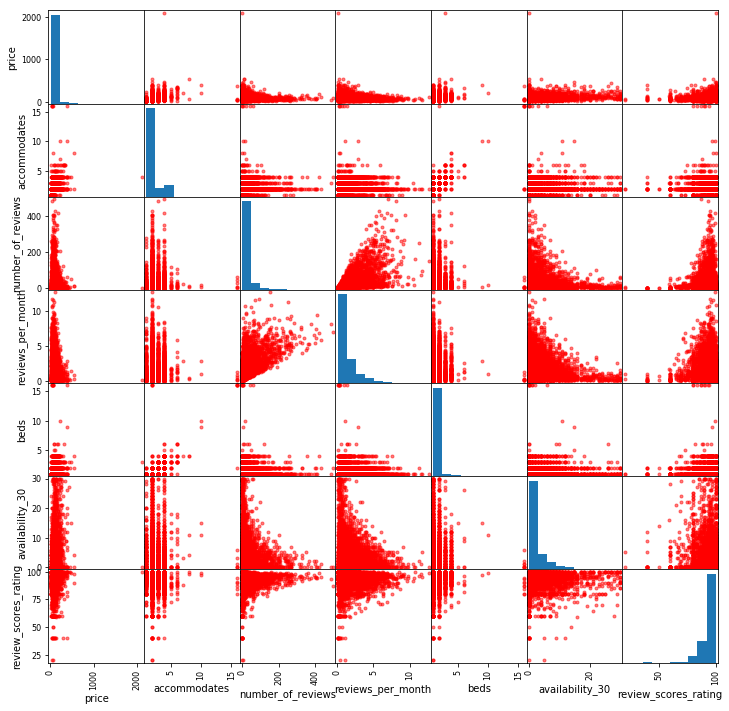

In [6]:
## collinearity 
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols], figsize=(12, 12), c='red')

### model 생성

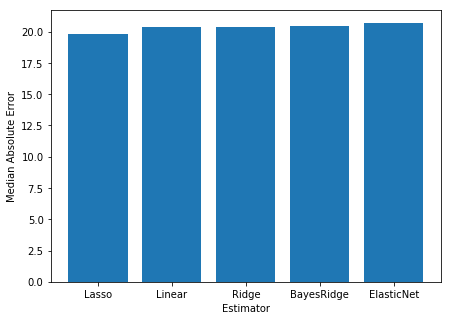

In [7]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge()]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

### model selction

In [8]:
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV

conf = SparkConf().setMaster('local[*]')
sc = SparkContext(conf=conf)

tuned_parameters = {
    "n_estimators": [ 250, 300, 350 ],
    "max_depth" : [ 3, 4, 5 ],
    "learning_rate": [ 0.01, 0.05, 0.1 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')

preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

c:\anaconda3\envs\spark\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\anaconda3\envs\spark\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [11]:
best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

### model evaluation

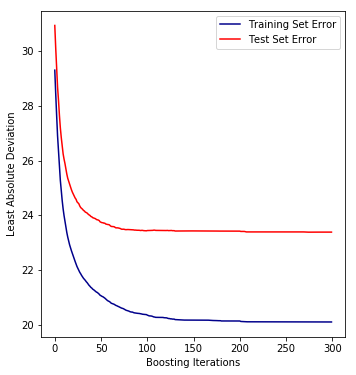

In [12]:
test_score = np.zeros(best.n_estimators, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(best.n_estimators), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(best.n_estimators), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

### variable importance

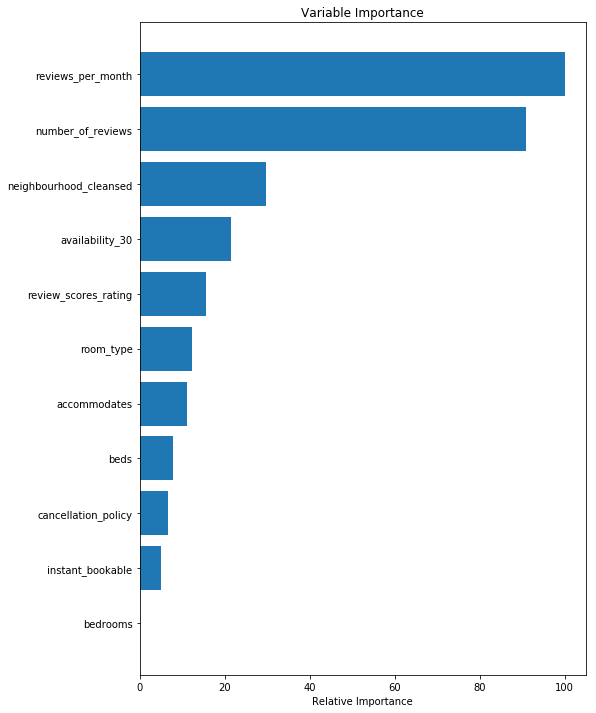

In [13]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')